In [1]:
import numpy as np
from scipy.integrate.odepack import odeint
import matplotlib.pyplot as plt

In /Applications/anaconda3/envs/fenicsproject/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Applications/anaconda3/envs/fenicsproject/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Applications/anaconda3/envs/fenicsproject/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Applications/anaconda3/envs/fenicsproject/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two mi

In [2]:
import chondrocyte
from params import params_dict

In [3]:
# define time span
params_dict["t_final"] = 100
t_final = params_dict["t_final"]
params_dict["dt"] = 1e-2
dt = params_dict["dt"]
t = np.linspace(0, t_final, int(t_final/dt))

In [4]:
# Define initial condition vector
y0 = (params_dict["V_0"], params_dict["Na_i_0"], params_dict["K_i_0"], params_dict["Ca_i_0"], params_dict["H_i_0"], 
      params_dict["Cl_i_0"], params_dict["a_ur_0"], params_dict["i_ur_0"], params_dict["vol_i_0"], 
      params_dict["cal_0"])

In [5]:
#step throught holding potentials
def HoldingPotential(solution):
    V = solution[:,0]
    longth = V.shape[0]
    # get steady-state ion concentrations
    Ca_i_ss = solution[:,3][longth-1]

    V_step_size = 2501
    VV = np.linspace(-150, 100, V_step_size)

    current_dict = {
        "I_K_DR" : np.zeros(V_step_size), 
        "I_NaK" : np.zeros(V_step_size),
        "I_NaCa" : np.zeros(V_step_size), 
        "I_Ca_ATP" : np.zeros(V_step_size),
        "I_K_ATP" : np.zeros(V_step_size),
        "I_K_2pore": np.zeros(V_step_size),
        "I_Na_b" : np.zeros(V_step_size),
        "I_K_b" : np.zeros(V_step_size),
        "I_Cl_b" : np.zeros(V_step_size),
        "I_leak" : np.zeros(V_step_size),
        "I_bq" : np.zeros(V_step_size),
        "I_BK" : np.zeros(V_step_size),
        "I_TRPV4" : np.zeros(V_step_size),
        "I_RMP" : np.zeros(V_step_size), 
        "I_total" : np.zeros(V_step_size)
        }

    C_m = params_dict["C_m"]

    for i in range(V_step_size):

        # I_K_DR (printed in pA/pF)
        current_dict["I_K_DR"][i] = chondrocyte.DelayedRectifierPotassium(V=VV[i], enable_I_K_DR=True)/C_m

        # I_Na_K (pA; printed IV pA/pF)
        current_dict["I_NaK"][i]= chondrocyte.sodiumPotassiumPump(V=VV[i], K_o=params_dict["K_o"], Na_i_0=params_dict["Na_i_clamp"], enable_I_NaK=True)/C_m

        # I_NaCa (pA; printed IV pA/pF)
        current_dict["I_NaCa"][i] = chondrocyte.sodiumCalciumExchanger(V=VV[i], Ca_i=params_dict["Ca_i_0"], Na_i_0=params_dict["Na_i_clamp"], enable_I_NaCa=True)/C_m

        # I_Ca_ATP (pA)
        current_dict["I_Ca_ATP"][i] = chondrocyte.calciumPump(Ca_i=Ca_i_ss, enable_I_Ca_ATP=True)

        # I_K_ATP (pA?) Zhou/Ferrero, Biophys J, 2009
        # TODO: it is complex number in the beginning of iterations. need to fix (by Kei)
        current_dict["I_K_ATP"][i] = chondrocyte.potassiumPump(V=VV[i], K_i=0, K_o=params_dict["K_o"],E_K=-94.02, enable_I_K_ATP=True)

        # I_K_2pore (pA; pA/pF in print) 
        # modeled as a simple Boltzmann relationship via GHK, scaled to match isotonic K+ data from Bob Clark
        current_dict["I_K_2pore"][i] = chondrocyte.twoPorePotassium(V=VV[i], K_i_0=params_dict["K_i_0"], K_o=params_dict["K_o"], Q=params_dict["Q"], enable_I_K_2pore=True)/C_m

        # I_Na_b (pA; pA/pF in print)
        current_dict["I_Na_b"][i] = chondrocyte.backgroundSodium(V=VV[i], Na_i=None, E_Na=params_dict["E_Na"], enable_I_Na_b=True)/C_m

        # I_K_b (pA; pA/pF in print)
        current_dict["I_K_b"][i] = chondrocyte.backgroundPotassium(V=VV[i], K_i=None, K_o=None, g_K_b_bar=params_dict["g_K_b_bar"], E_K=-83, enable_I_K_b=True)/C_m

        # I_Cl_b (pA; pA/pF in print)
        current_dict["I_Cl_b"][i] = chondrocyte.backgroundChloride(V=VV[i], Cl_i=None, enable_I_Cl_b=True)/C_m

        # I_leak (pA); not printed, added to I_bg
        current_dict["I_leak"][i] = chondrocyte.backgroundLeak(V=VV[i], enable_I_leak=False)

        # I_bg (pA; pA/pF in print)
        current_dict["I_bq"][i] = current_dict["I_Na_b"][i] + current_dict["I_K_b"][i] + current_dict["I_Cl_b"][i] + current_dict["I_leak"][i]

        # I_K_Ca_act (new version) (pA; pA/pF in print), with converted Ca_i units for model
        current_dict["I_BK"][i] = chondrocyte.calciumActivatedPotassium(V=VV[i], Ca_i=params_dict["Ca_i_0"], enable_I_K_Ca_act=True)/C_m

        # I TRPV4 (pA; pA/pF in print)
        current_dict["I_TRPV4"][i] = chondrocyte.TripCurrent(V=VV[i], enable_I_TRPV4=True)/C_m

        # I_RMP (pA; pA/pF in print)
        current_dict["I_RMP"][i] = current_dict["I_bq"][i] + current_dict["I_BK"][i] + current_dict["I_K_DR"][i] \
                                + current_dict["I_NaCa"][i] + current_dict["I_NaK"][i] + current_dict["I_K_2pore"][i]

        # I_total (pA)
        # TODO: not yet verifiyed due to "I_K_ATP"(by Kei)
        current_dict["I_total"][i] = current_dict["I_NaK"][i]*C_m + current_dict["I_NaCa"][i]*C_m + current_dict["I_Ca_ATP"][i] + \
                            current_dict["I_K_DR"][i]*C_m +  current_dict["I_K_2pore"][i]*C_m + current_dict["I_K_ATP"][i] + \
                            current_dict["I_BK"][i] + current_dict["I_Na_b"][i]*C_m + current_dict["I_K_b"][i]*C_m + \
                            current_dict["I_Cl_b"][i]*C_m + current_dict["I_leak"][i] + current_dict["I_TRPV4"][i]*C_m

    return (VV, current_dict)

In [6]:
#solve the ODE system which is imported with chondrocyte
solution10 = odeint(chondrocyte.rhs, y0, t, args=(params_dict,))

In [7]:
VV, current10 = HoldingPotential(solution10)

In [8]:
# update parameter
params_dict["Ca_i_0"] = 0.000175

In [9]:
solution175 = odeint(chondrocyte.rhs, y0, t, args=(params_dict,))

In [10]:
VV, current175 = HoldingPotential(solution175)

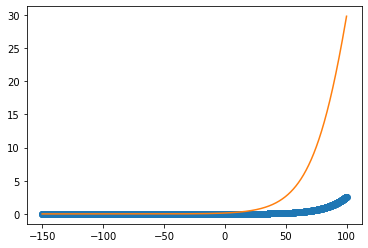

In [11]:
plt.plot(VV, current10["I_BK"], "o")
plt.plot(VV, current175["I_BK"], "-")

In [ ]:
params_dict